# Sprint
## 機械学習スクラッチ 決定木
スクラッチで決定木を実装した後、学習と検証を行なっていきます。

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


決定木の学習には何回まで条件分岐を繰り返すかを表す **（最大の）深さ** というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。


学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている **CART法** をベースとした実装を行います。この方法では学習の複雑さを減らすために、 **分岐は2つに分かれるのみ** になります。


以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

In [1]:
import numpy as np
import time
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.node : (column, threshold, left, right, information_gain)
      ノードの情報
      column : int
        分岐に使用する列番号
      threshold : float
        分岐の閾値
      left : int
        value < thereshold だった場合のクラス
      right : int
        thereshold <= value だった場合のクラス
      information_gain : float
        情報利得の値

    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # preprocessing
        ## 親ノードの初期化
        self.node = (0, 0, 0, 0, 0)

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')

        start_time = time.time()
        
        # learning
        self.node = self._make_node(X, y)
        if self.verbose:
            print(self.node)
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = np.where(X[:, self.node[0]] < self.node[1], self.node[2], self.node[3])

        return y_pred

    def _get_gini(self, y):
        """
        あるノードにおけるジニ不純度を計算する

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            float
            あるノードのジニ不順度
        """
        # number of all samples
        n = y.shape[0]
        # counts of each classes
        _, counts = np.unique(y, return_counts=True)
        
        _gini = 1 - np.sum((counts/n)**2)

        return _gini

    def _get_information_gain(self, y_left, y_right):
        """
        ノード間の情報利得を計算する

        Parameters
        ----------
        y_left : 次の形のndarray, shape (n_samples_to_left, )
            左ノードにおける訓練データの正解値
        y_right : 次の形のndarray, shape (n_samples_to_right, )
            右ノードにおける訓練データの正解値

        Returns
        -------
            float
            親子ノード間の情報利得
        """
        # get labels on p-node
        y_parent = np.hstack((y_left, y_right))
        
        # get num of samples
        n_parent = y_parent.shape[0]
        n_left = y_left.shape[0]
        n_right = y_right.shape[0]

        # get gini
        gini_p = _get_gini_sample(y_parent)
        gini_l = _get_gini_sample(y_left)
        gini_r = _get_gini_sample(y_right)

        inf_gain = gini_p - ((n_left/n_parent)*gini_l) - ((n_right/n_parent)*gini_r)
        
        return inf_gain

    def _make_node(self, X, y):
        """
        情報利得が最大化されるノードを作成する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            (column, threshold, left, right, information_gain)
            新しく作成されたノード
        """
        tmp_node = (0, 0, 0, 0, 0)

        for row, label in zip(X, y):
            for col_num in range(row.shape[0]):
                _threshold = row[col_num]
                
                # splited y
                y_left = y[X[:, col_num] < _threshold]
                y_right = y[X[:, col_num] >= _threshold]
                
                # get information gain
                tmp_info_gain = self._get_information_gain(y_left, y_right)

                if tmp_info_gain > tmp_node[4]:
                    # make temporary node
                    tmp_node = (col_num, _threshold, 1-label, label, tmp_info_gain)
                
                ## output process
                if self.verbose:
                    print(f'[X[:, {col_num}] >= {_threshold}] -> {label} : {tmp_info_gain}')
        
        return tmp_node

# 【問題1】
## 不純度を求める関数
**ノード** の **ジニ不純度** を計算する関数を作成してください。ノード $t$に対するジニ不純度$I(t)$は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。 
$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$
$t$ : ノードのインデックス


$i$ : クラスのインデックス


$K$ : クラスの数

$C_i$ : i番目のクラス


$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合


$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数


$N_{t,all}$ : t番目のノードのサンプルの総数


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》

- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

```python
    def _get_gini(self, y):
        """
        あるノードにおけるジニ不純度を計算する

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            float
            あるノードのジニ不順度
        """
        # number of all samples
        n = y.shape[0]
        # counts of each classes
        _, counts = np.unique(y, return_counts=True)
        
        _gini = 1 - np.sum((counts/n)**2)

        return _gini
```

In [2]:
# 動作確認
def _get_gini_sample(y):
    # number of all samples
    n = y.shape[0]
    # counts of each classes
    _, counts = np.unique(y, return_counts=True)

    _gini = 1 - np.sum((counts/n)**2)

    return _gini

In [3]:
y1 = np.hstack((np.tile(1, 15), np.tile(2, 15)))
y2 = np.hstack((np.tile(1, 15), np.tile(2, 15), np.tile(3, 15)))
y3 = np.hstack((np.tile(1, 18), np.tile(2, 12)))
y4 = np.hstack((np.tile(1, 30), np.tile(2, 0)))
print(y1)
print(y2)
print(y3)
print(y4)
print(f'gini y1: {_get_gini_sample(y1)}')
print(f'gini y2: {_get_gini_sample(y2)}')
print(f'gini y3: {_get_gini_sample(y3)}')
print(f'gini y4: {_get_gini_sample(y4)}')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
gini y1: 0.5
gini y2: 0.6666666666666667
gini y3: 0.48
gini y4: 0.0


# 【問題2】
## 情報利得を求める関数
次に、ノード間の **情報利得** を計算する関数を作成してください。問題1で作成したジニ不純度$I(t)$を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。


ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。
$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$
$p$ : 親ノードを示すインデックス


$left$ : 左側のノードを示すインデックス


$right$ : 右側のノードを示すインデックス


まずは簡単な例を作り、手計算と関数の結果を比較してください。


**《例》**


左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

```python
    def _get_information_gain(self, y_left, y_right):
        """
        ノード間の情報利得を計算する

        Parameters
        ----------
        y_left : 次の形のndarray, shape (n_samples_to_left, )
            左ノードにおける訓練データの正解値
        y_right : 次の形のndarray, shape (n_samples_to_right, )
            右ノードにおける訓練データの正解値

        Returns
        -------
            float
            親子ノード間の情報利得
        """
        # get labels on p-node
        y_parent = np.hstack((y_left, y_right))
        
        # get num of samples
        n_parent = y_parent.shape[0]
        n_left = y_left.shape[0]
        n_right = y_right.shape[0]

        # get gini
        gini_p = _get_gini_sample(y_parent)
        gini_l = _get_gini_sample(y_left)
        gini_r = _get_gini_sample(y_right)

        inf_gain = gini_p - ((n_left/n_parent)*gini_l) - ((n_right/n_parent)*gini_r)
        
        return inf_gain
```

In [4]:
# 動作確認
def _get_information_gain_sample(y_left, y_right):
    # get labels on p-node
    y_parent = np.hstack((y_left, y_right))
    
    # get num of samples
    n_parent = y_parent.shape[0]
    n_left = y_left.shape[0]
    n_right = y_right.shape[0]

    # get gini
    gini_p = _get_gini_sample(y_parent)
    gini_l = _get_gini_sample(y_left)
    gini_r = _get_gini_sample(y_right)

    inf_gain = gini_p - ((n_left/n_parent)*gini_l) - ((n_right/n_parent)*gini_r)
    
    return inf_gain

In [5]:
y1 = np.hstack((np.tile(1, 10), np.tile(2, 30)))
y2 = np.hstack((np.tile(1, 20), np.tile(2, 5)))

print(f'information gain: {_get_information_gain_sample(y1, y2)}')

information gain: 0.14319526627218937


# 【問題3】
## 学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが **葉ノード** となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


**《組み合わせの取り方》**


全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


**《補足》**


問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度$I(p)$は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

```python
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # preprocessing
        ## 親ノードの初期化
        self.node = (0, 0, 0, 0, 0)

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')

        start_time = time.time()
        
        # learning
        self.node = _make_node(X, y)
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'{self.iter} Done! elapsed time: {elapsed_time:.5f}s')
```
```python
    def _make_node(self, X, y):
        """
        情報利得が最大化されるノードを作成する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            (column, threshold, left, right, information_gain)
            新しく作成されたノード
        """
        tmp_node = (0, 0, 0, 0, 0)

        for row, label in zip(X, y):
            for col_num in range(row.shape[0]):
                _threshold = row[col_num]
                
                # splited y
                y_left = y[X[:, col_num] < _threshold]
                y_right = y[X[:, col_num] >= _threshold]
                
                # get information gain
                tmp_info_gain = _get_information_gain(y_left, y_right)

                if tmp_info_gain > tmp_node:
                    # make temporary node
                    tmp_node = (col_num, _threshold, 1-label, label, tmp_info_gain)
                
                ## output process
                if self.verbose:
                    print(f'[X[:, {col_num}] >= {_threshold}] -> {label} : {tmp_info_gain}')
        
        return tmp_node
```

# 【問題4】
## 推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

```python
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = np.where(X[:, self.node[0]] >= self.node[1], self.node[1], self.node[1])

        return y_pred
```

# 【問題5】
## 学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [6]:
# シンプルデータセット2
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [8]:
# 学習
dtree1 = ScratchDecesionTreeClassifierDepth1(verbose=True)
dtree1.fit(X_train_std, y_train)

start learning
[X[:, 0] >= -0.922302469704527] -> 1 : 0.013888888888888729
[X[:, 1] >= -0.6993632099715235] -> 1 : 0.06613756613756616
[X[:, 0] >= -0.598417390361828] -> 1 : 0.002645502645502673
[X[:, 1] >= -0.4929030821274408] -> 1 : 0.05980861244019142
[X[:, 0] >= 0.6215223959087645] -> 1 : 0.0215311004784689
[X[:, 1] >= 1.3361647322338568] -> 1 : 0.09999999999999998
[X[:, 0] >= 0.7467010804071721] -> 0 : 0.002645502645502673
[X[:, 1] >= 0.004200258191307213] -> 0 : 0.03703703703703712
[X[:, 0] >= 0.7198271507488434] -> 1 : 0.01000000000000012
[X[:, 1] >= 0.6697880894884577] -> 1 : 0.07763975155279507
[X[:, 0] >= 0.331568134401967] -> 1 : 0.0
[X[:, 1] >= 1.3978047125469935] -> 1 : 0.07692307692307687
[X[:, 0] >= -2.964769252557129] -> 1 : 0.0
[X[:, 1] >= -0.2301124262659325] -> 1 : 0.035714285714285726
[X[:, 0] >= 1.0090797159422389] -> 0 : 0.004000000000000031
[X[:, 1] >= -0.2874007967562313] -> 0 : 0.020000000000000018
[X[:, 0] >= 1.3075385586442052] -> 1 : 0.017241379310344862
[X[

In [9]:
# 予測・評価
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
y_pred = dtree1.predict(X_test_std)
print(f'true: {y_test}')
print(f'pred: {y_pred}')
print(f'Accuracy:   {accuracy_score(y_test, y_pred)}')
print(f'Precision:  {precision_score(y_test, y_pred)}')
print(f'Recall:     {recall_score(y_test, y_pred)}')
print(f'F1:         {f1_score(y_test, y_pred)}')
print(f'confusion matrix:\n{confusion_matrix(y_test, y_pred)}')

true: [1 1 1 0 0 0 1 0 0 1]
pred: [1 0 0 0 0 0 0 0 1 1]
Accuracy:   0.6
Precision:  0.6666666666666666
Recall:     0.4
F1:         0.5
confusion matrix:
[[4 1]
 [3 2]]


In [10]:
# sklearn版との比較
from sklearn.tree import DecisionTreeClassifier
dtree1_sk = DecisionTreeClassifier(max_depth=1)
dtree1_sk.fit(X_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
# 予測・評価
y_pred_sk = dtree1_sk.predict(X_test_std)
print(f'true: {y_test}')
print(f'pred: {y_pred_sk}')
print(f'Accuracy:   {accuracy_score(y_test, y_pred_sk)}')
print(f'Precision:  {precision_score(y_test, y_pred_sk)}')
print(f'Recall:     {recall_score(y_test, y_pred_sk)}')
print(f'F1:         {f1_score(y_test, y_pred_sk)}')
print(f'confusion matrix:\n{confusion_matrix(y_test, y_pred_sk)}')

true: [1 1 1 0 0 0 1 0 0 1]
pred: [1 0 0 0 0 0 0 0 1 1]
Accuracy:   0.6
Precision:  0.6666666666666666
Recall:     0.4
F1:         0.5
confusion matrix:
[[4 1]
 [3 2]]


予測結果・評価値は等しくなった。

sklearn版と比較しても正しく動作していると考えられる。

# 【問題6】
## 決定領域の可視化
決定領域を可視化してください。

In [12]:
# スクラッチ実装
## train
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree1.predict(X_tmp).reshape(xx.shape)

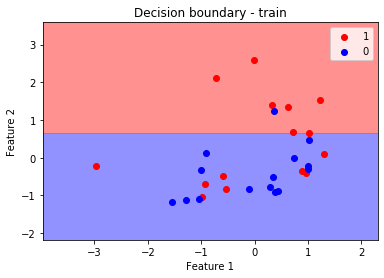

In [13]:
import matplotlib.pyplot as plt

X_train_pos = X_train_std[np.where(y_train==1)]
X_train_nega = X_train_std[np.where(y_train==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='red', label="1")
plt.scatter(X_train_nega[:, 0], X_train_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

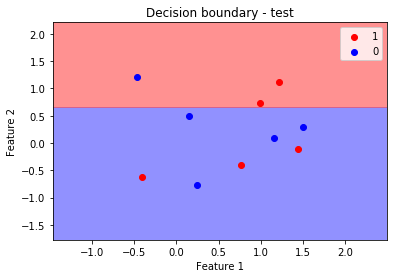

In [14]:
## test
x_min, x_max = X_test_std[:, 0].min() - 1, X_test_std[:, 0].max() + 1
y_min, y_max = X_test_std[:, 1].min() - 1, X_test_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree1.predict(X_tmp).reshape(xx.shape)

X_test_pos = X_test_std[np.where(y_test==1)]
X_test_nega = X_test_std[np.where(y_test==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], c='red', label="1")
plt.scatter(X_test_nega[:, 0], X_test_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

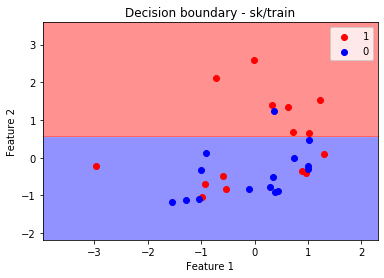

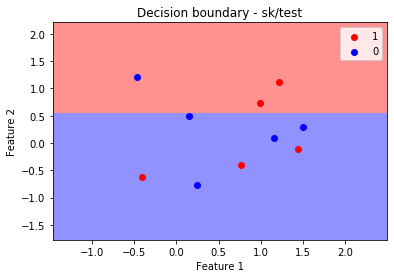

In [15]:
# sklearn実装版
## train
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree1_sk.predict(X_tmp).reshape(xx.shape)

X_train_pos = X_train_std[np.where(y_train==1)]
X_train_nega = X_train_std[np.where(y_train==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - sk/train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='red', label="1")
plt.scatter(X_train_nega[:, 0], X_train_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

## test
x_min, x_max = X_test_std[:, 0].min() - 1, X_test_std[:, 0].max() + 1
y_min, y_max = X_test_std[:, 1].min() - 1, X_test_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree1_sk.predict(X_tmp).reshape(xx.shape)

X_test_pos = X_test_std[np.where(y_test==1)]
X_test_nega = X_test_std[np.where(y_test==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - sk/test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], c='red', label="1")
plt.scatter(X_test_nega[:, 0], X_test_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

# 【問題7】
## （アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。


深さ2とは空間の分割を2回行うことを指します。


**《ヒント》**


各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

In [16]:
class ScratchDecesionTreeClassifierDepth2():
    """
    深さ2の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.root_node : Node
        根ノード

    """
    class Node:
        """
        ノードを表す内部クラス

        Parameters
        ----------
        verbose : bool
        学習過程を出力する場合はTrue

        Attributes
        ----------
        col_num : int
            分岐に使用する列番号
        threshold : float
            分岐の閾値
        left : Node/Leaf
            value < thereshold だった場合のノード
        right : Node/Leaf
            thereshold <= value だった場合のノード
        information_gain : float
            情報利得の値

        """
        def __init__(self, col_num=0, threshold=0, left=None, right=None, information_gain=0):
            self.col_num = col_num
            self.threshold = threshold
            self.left = left
            self.right = right
            self.information_gain = information_gain
        
        def __str__(self):
            return f'col_num: {self.col_num}\nthreshold: {self.threshold}\nleft: \n{{\n{self.left}\n}}\nright: \n{{\n{self.right}\n}}\ninformation_gain: {self.information_gain}' 

        def distribute_data(self, X):
            """
            親ノードから渡されたデータを子ノードに分配し予測する

            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                親ノードから渡された訓練データの特徴量

            """
            # distribute and pred data
            y_pred = np.where(X[:, self.col_num ] < self.threshold,
                                self.left.distribute_data(X),
                                self.right.distribute_data(X))
            return y_pred

    class Leaf:
        """
        葉ノードを表す内部クラス

        Parameters
        ----------
        column : int
            分岐に使用する列番号
        threshold : float
            分岐の閾値
        left : int
            value < thereshold だった場合のクラス
        right : int
            thereshold <= value だった場合のクラス
        information_gain : float
            情報利得の値
        
        Attributes
        ----------

        """
        def __init__(self, col_num=0, threshold=0, left=0, right=0, information_gain=0):
            self.col_num = col_num
            self.threshold = threshold
            self.left = left
            self.right = right
            self.information_gain = information_gain
        
        def __str__(self):
            return f'col_num: {self.col_num}\nthreshold: {self.threshold}\nleft: {self.left}\nright: {self.right}\ninformation_gain: {self.information_gain}' 
        
        def distribute_data(self, X):
            """
            親ノードから渡されたデータのクラスを予測する

            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                親ノードから渡された訓練データの特徴量

            """
            # distribute and pred data
            y_pred = np.where(X[:, self.col_num ] < self.threshold, self.left, self.right)

            return y_pred

    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # preprocessing
        ## 根ノードの初期化
        self.root_node = self.Node()

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')

        start_time = time.time()
        
        # learning
        self.root_node = self._make_node(X, y)
        if self.verbose:
            print(self.root_node)
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = self.root_node.distribute_data(X)

        return y_pred

    def _get_gini(self, y):
        """
        あるノードにおけるジニ不純度を計算する

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            float
            あるノードのジニ不順度
        """
        # number of all samples
        n = y.shape[0]
        # counts of each classes
        _, counts = np.unique(y, return_counts=True)
        
        _gini = 1 - np.sum((counts/n)**2)

        return _gini

    def _get_information_gain(self, y_left, y_right):
        """
        ノード間の情報利得を計算する

        Parameters
        ----------
        y_left : 次の形のndarray, shape (n_samples_to_left, )
            左ノードにおける訓練データの正解値
        y_right : 次の形のndarray, shape (n_samples_to_right, )
            右ノードにおける訓練データの正解値

        Returns
        -------
            float
            親子ノード間の情報利得
        """
        # get labels on p-node
        y_parent = np.hstack((y_left, y_right))
        
        # get num of samples
        n_parent = y_parent.shape[0]
        n_left = y_left.shape[0]
        n_right = y_right.shape[0]

        # get gini
        gini_p = _get_gini_sample(y_parent)
        gini_l = _get_gini_sample(y_left)
        gini_r = _get_gini_sample(y_right)

        inf_gain = gini_p - ((n_left/n_parent)*gini_l) - ((n_right/n_parent)*gini_r)
        
        return inf_gain

    def _make_node(self, X, y):
        """
        情報利得が最大化されるノードを作成する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            新しく作成されたノード
        """
        tmp_node = self.Node()
        
        # 1st hiarchy
        if self.verbose:
            print('1st hiarchy')
        for row, label in zip(X, y):
            for col_num in range(row.shape[0]):
                _threshold = row[col_num]
                
                ## splited y
                y_left = y[X[:, col_num] < _threshold]
                y_right = y[X[:, col_num] >= _threshold]
                
                ## get information gain
                tmp_info_gain = self._get_information_gain(y_left, y_right)

                if tmp_info_gain > tmp_node.information_gain:
                    tmp_node = self.Node(col_num, _threshold, self.Leaf(), self.Leaf(), tmp_info_gain)
                
                ## output process
                if self.verbose:
                    print(f'[X[:, {col_num}] >= {_threshold}] -> {label} : {tmp_info_gain}')

        # 2nd hiarchy
        if self.verbose:
            print('2nd hiarchy')
        ## splited X and y
        left_index = X[:, col_num] < tmp_node.threshold
        right_index = X[:, col_num] >= tmp_node.threshold

        X_left = X[left_index]
        X_right = X[right_index]

        y_left = y[left_index]
        y_right = y[right_index]
        ## make leaf
        tmp_node.left = self._make_leaf(X_left, y_left)
        tmp_node.right = self._make_leaf(X_right, y_right)

        return tmp_node

    def _make_leaf(self, X, y):
        """
        葉を作成する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値

        Returns
        -------
            新しく作成された葉ノード
        """
        tmp_leaf = self.Leaf()

        for row, label in zip(X, y):
            for col_num in range(row.shape[0]):
                _threshold = row[col_num]
                
                # splited y
                y_left = y[X[:, col_num] < _threshold]
                y_right = y[X[:, col_num] >= _threshold]
                
                # get information gain
                tmp_info_gain = self._get_information_gain(y_left, y_right)

                if tmp_info_gain > tmp_leaf.information_gain:
                    # make temporary node
                    tmp_leaf = self.Leaf(col_num, _threshold, 1-label, label, tmp_info_gain)
                
                ## output process
                if self.verbose:
                    print(f'[X[:, {col_num}] >= {_threshold}] -> {label} : {tmp_info_gain}')
        
        return tmp_leaf

In [17]:
# 学習
dtree2 = ScratchDecesionTreeClassifierDepth2(verbose=True)
dtree2.fit(X_train_std, y_train)

start learning
1st hiarchy
[X[:, 0] >= -0.922302469704527] -> 1 : 0.013888888888888729
[X[:, 1] >= -0.6993632099715235] -> 1 : 0.06613756613756616
[X[:, 0] >= -0.598417390361828] -> 1 : 0.002645502645502673
[X[:, 1] >= -0.4929030821274408] -> 1 : 0.05980861244019142
[X[:, 0] >= 0.6215223959087645] -> 1 : 0.0215311004784689
[X[:, 1] >= 1.3361647322338568] -> 1 : 0.09999999999999998
[X[:, 0] >= 0.7467010804071721] -> 0 : 0.002645502645502673
[X[:, 1] >= 0.004200258191307213] -> 0 : 0.03703703703703712
[X[:, 0] >= 0.7198271507488434] -> 1 : 0.01000000000000012
[X[:, 1] >= 0.6697880894884577] -> 1 : 0.07763975155279507
[X[:, 0] >= 0.331568134401967] -> 1 : 0.0
[X[:, 1] >= 1.3978047125469935] -> 1 : 0.07692307692307687
[X[:, 0] >= -2.964769252557129] -> 1 : 0.0
[X[:, 1] >= -0.2301124262659325] -> 1 : 0.035714285714285726
[X[:, 0] >= 1.0090797159422389] -> 0 : 0.004000000000000031
[X[:, 1] >= -0.2874007967562313] -> 0 : 0.020000000000000018
[X[:, 0] >= 1.3075385586442052] -> 1 : 0.0172413793

In [18]:
# 予測・評価
y_pred = dtree2.predict(X_test_std)
print(f'true: {y_test}')
print(f'pred: {y_pred}')
print(f'Accuracy:   {accuracy_score(y_test, y_pred)}')
print(f'Precision:  {precision_score(y_test, y_pred)}')
print(f'Recall:     {recall_score(y_test, y_pred)}')
print(f'F1:         {f1_score(y_test, y_pred)}')
print(f'confusion matrix:\n{confusion_matrix(y_test, y_pred)}')

true: [1 1 1 0 0 0 1 0 0 1]
pred: [0 1 1 1 1 1 1 1 0 0]
Accuracy:   0.4
Precision:  0.42857142857142855
Recall:     0.6
F1:         0.5
confusion matrix:
[[1 4]
 [2 3]]


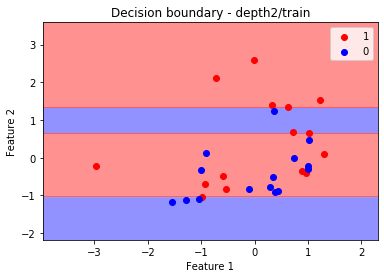

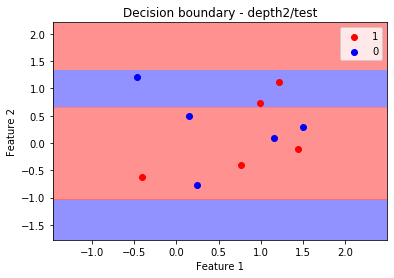

In [19]:
# 可視化
## train
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree2.predict(X_tmp).reshape(xx.shape)

X_train_pos = X_train_std[np.where(y_train==1)]
X_train_nega = X_train_std[np.where(y_train==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - depth2/train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='red', label="1")
plt.scatter(X_train_nega[:, 0], X_train_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

## test
x_min, x_max = X_test_std[:, 0].min() - 1, X_test_std[:, 0].max() + 1
y_min, y_max = X_test_std[:, 1].min() - 1, X_test_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree2.predict(X_tmp).reshape(xx.shape)

X_test_pos = X_test_std[np.where(y_test==1)]
X_test_nega = X_test_std[np.where(y_test==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - depth2/test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], c='red', label="1")
plt.scatter(X_test_nega[:, 0], X_test_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

In [33]:
# sklearn版との比較
from sklearn.tree import DecisionTreeClassifier
dtree2_sk = DecisionTreeClassifier(max_depth=2)
dtree2_sk.fit(X_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [34]:
# 予測・評価
y_pred_sk = dtree2_sk.predict(X_test_std)
print(f'true: {y_test}')
print(f'pred: {y_pred_sk}')
print(f'Accuracy:   {accuracy_score(y_test, y_pred_sk)}')
print(f'Precision:  {precision_score(y_test, y_pred_sk)}')
print(f'Recall:     {recall_score(y_test, y_pred_sk)}')
print(f'F1:         {f1_score(y_test, y_pred_sk)}')
print(f'confusion matrix:\n{confusion_matrix(y_test, y_pred_sk)}')

true: [1 1 1 0 0 0 1 0 0 1]
pred: [1 0 0 0 0 0 0 0 1 1]
Accuracy:   0.6
Precision:  0.6666666666666666
Recall:     0.4
F1:         0.5
confusion matrix:
[[4 1]
 [3 2]]


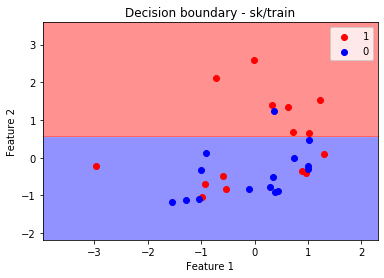

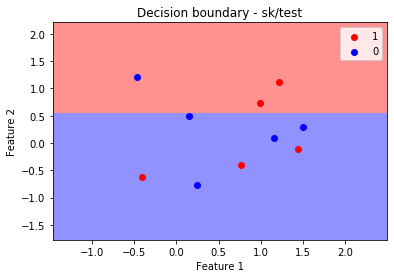

In [35]:
# sklearn実装版
## train
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree2_sk.predict(X_tmp).reshape(xx.shape)

X_train_pos = X_train_std[np.where(y_train==1)]
X_train_nega = X_train_std[np.where(y_train==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - sk/train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='red', label="1")
plt.scatter(X_train_nega[:, 0], X_train_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

## test
x_min, x_max = X_test_std[:, 0].min() - 1, X_test_std[:, 0].max() + 1
y_min, y_max = X_test_std[:, 1].min() - 1, X_test_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = dtree2_sk.predict(X_tmp).reshape(xx.shape)

X_test_pos = X_test_std[np.where(y_test==1)]
X_test_nega = X_test_std[np.where(y_test==0)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - sk/test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], c='red', label="1")
plt.scatter(X_test_nega[:, 0], X_test_nega[:, 1], c='blue', label="0")

plt.legend()
plt.show()

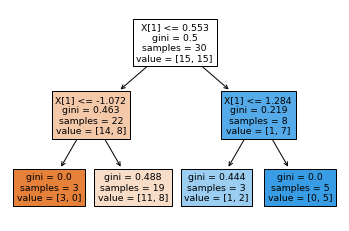

In [30]:
from sklearn.tree import plot_tree
%matplotlib inline
_ = plot_tree(dtree2_sk, filled=True)

In [23]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(
    clf,
    iris.data, 
    iris.target,
    target_name='variety',
    feature_names=iris.feature_names,
    class_names=[str(i) for i in iris.target_names],
) 

viz.view()

スクラッチ実装については2階層にすることで精度の向上はみられなかった。図を見ても、2層目の分割境界があまり役に立っていないだろうことがわかる。

sklearnについては予測結果としては1階層の場合と同じになった（精度の向上がみられなかったため？）

しかし、内部のツリー構造を可視化したところ2階層構造となっており、2層目ではスクラッチ実装に近い閾値での分割が行われたことが見て取れる。

# 【問題8】
## （アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。